In [45]:
params_export_flag = False

input_directory = "../results/gene_sets_overlaps/"

input_config_filepaths = None

# Comparative genomics - mouse / human binding sites orthologies

## Overview

NOTE: previous nomenclature used "peaks" instead of binding sites. In this context they both designate any short (< 100 nt) genomic interval associated with experimentally measured signal of RBP binding as
identified in previous steps.

## Imports

In [86]:
import pandera
import functools
import pandas as pd
from dotmap import DotMap
import numpy as np
import os
import sys
from pathlib import Path
import yaml

from numbers import Number
from typing import Sequence, List, Set, Union, Tuple, Optional

import pybedtools as pbt


In [110]:
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
import matplotlib_venn as venn
import seaborn as sns

from matplotlib import rc
import matplotlib_venn as venn
import matplotlib_inline

try:
    matplotlib.font_manager.findfont("Arial")
    mpl.rcParams["font.sans-serif"] = ["Arial"]
except Exception as e:
    print(f"Arial font not found: {e}")
    mpl.rcParams["font.sans-serif"] = ["DejaVu Sans"]

rc("text", usetex=False)


FONT_SMALL_SIZE = 16
FONT_MEDIUM_SIZE = 20
FONT_BIGGER_SIZE = 22

mpl.rc("font", size=FONT_SMALL_SIZE)  # controls default text sizes
mpl.rc("axes", titlesize=FONT_SMALL_SIZE)  # fontsize of the axes title
mpl.rc("axes", labelsize=FONT_MEDIUM_SIZE)  # fontsize of the x and y labels
mpl.rc("xtick", labelsize=FONT_SMALL_SIZE)  # fontsize of the tick labels
mpl.rc("ytick", labelsize=FONT_SMALL_SIZE)  # fontsize of the tick labels
mpl.rc("legend", fontsize=FONT_SMALL_SIZE)  # legend fontsize
mpl.rc("figure", titlesize=FONT_BIGGER_SIZE)  # fontsize of the figure title

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

DEFAULT_FIGSIZE = (10, 6)
plt.rcParams["figure.figsize"] = DEFAULT_FIGSIZE
plt.rcParams["axes.spines.top"] = True
plt.rcParams["axes.spines.right"] = True
plt.rcParams["font.size"] = FONT_SMALL_SIZE
plt.rcParams["figure.titlesize"] = FONT_BIGGER_SIZE
plt.rcParams["xtick.labelsize"] = FONT_MEDIUM_SIZE
plt.rcParams["ytick.labelsize"] = FONT_MEDIUM_SIZE
plt.rcParams["axes.axisbelow"] = True

## Definitions

In [87]:
def has_array_one_value_greater_than_others(arr: Sequence[Number]) -> bool:
    if len(arr) == 0:
        raise ValueError("Empty array")

    if len(arr) == 1:
        return True

    else:
        arr_s = sorted(arr, reverse=True)
        if arr_s[0] > arr_s[1]:
            return True
        else:
            return False


def build_identifier_bed6(row_bed6: pd.Series) -> str:
    """Build a sequence identifier as {chrom}:{start}-{end}:{strand} from BED6 row."""
    return row_bed6["chrom"] + ":" + str(row_bed6["start"]) + "-" + str(row_bed6["end"]) + ":" + row_bed6["strand"]


def series_extract_set_annotation(column: pd.Series) -> list[set[str]]:
    expected_format_delimiters = "NULL;NULL.NULL;;NULL"
    list_extracted_annotations = (
        column.replace(np.nan, expected_format_delimiters)
        .str.split(";;")
        .map(lambda v: list(map(lambda elem: elem.split(";")[0], v)))
        .map(set)
    ).tolist()
    return list_extracted_annotations


def series_extract_first_annotation(column: pd.Series) -> list[str]:
    expected_format_delimiters = "NULL;NULL.NULL;;NULL"
    list_extracted_annotations = (
        column.replace(np.nan, expected_format_delimiters).str.split(";;").str[0].str.split(";").str[0]
    ).tolist()
    return list_extracted_annotations


def series_extract_first_gene_id(column: pd.Series) -> list[str]:
    expected_format_delimiters = ";NULL.NULL;;NULL"
    list_extracted_ids = (
        column.replace(np.nan, expected_format_delimiters)
        .str.split(";;")
        .str[0]
        .str.split(";")
        .str[-1]
        .str.split(".")
        .str[0]
    ).tolist()
    return list_extracted_ids


def series_extract_set_geneid(column: pd.Series) -> list[set[str]]:
    expected_format_delimiters = "NULL;NULL.NULL;;NULL"
    list_extracted_annotations = (
        column.replace(np.nan, expected_format_delimiters)
        .str.split(";;")
        .map(lambda v: list(map(lambda elem: elem.split(";")[-1].split(".")[0], v)))
        .map(set)
    ).tolist()
    return list_extracted_annotations


def complete_bed6_table_with_additional_columns(df: pd.DataFrame) -> pd.DataFrame:
    df["identifier"] = df.apply(lambda row: build_identifier_bed6(row), axis=1)
    df["gene_id"] = series_extract_first_gene_id(df["name"])
    df["main_annot"] = series_extract_first_annotation(df["name"])
    df["annot_set"] = series_extract_set_annotation(df["name"])
    df["gene_id_set"] = series_extract_set_geneid(df["name"])

    return df


def load_bed6_table_and_complete_with_additional_columns(path: os.PathLike, columns: list[str]) -> pd.DataFrame:
    df = pd.read_csv(
        path,
        header=None,
        index_col=None,
        sep="\t",
        names=columns,
        comment="#",
    )

    df = complete_bed6_table_with_additional_columns(df)

    return df

In [96]:
class MousePeakIdentifierAndGeneOrthologiesSchema(pandera.DataFrameModel):
    identifier_mouse_source: pandera.typing.Series[str] = pandera.Field(alias="identifier.mouse_source", coerce=True)
    identifier_human_target: pandera.typing.Series[str] = pandera.Field(alias="identifier.human_target", coerce=True)
    orth_first_order: pandera.typing.Series[str] = pandera.Field(alias="orth_first_order", coerce=True, nullable=True)
    orth_second_order: pandera.typing.Series[str] = pandera.Field(alias="orth_second_order", coerce=True, nullable=True)
    orth_third_order_details: pandera.typing.Series[str] = pandera.Field(
        alias="orth_third_order.details", coerce=True, nullable=True
    )
    orth_third_order: pandera.typing.Series[str] = pandera.Field(alias="orth_third_order", coerce=True, nullable=True)
    gene_orthology_status: pandera.typing.Series[str] = pandera.Field(alias="gene_orthology_status", coerce=True)
    orthologous_gene_set: pandera.typing.Series[str] = pandera.Field(alias="orthologous_gene_set", coerce=True)
    annotated_lifted_region_bound_gene_set: pandera.typing.Series[str] = pandera.Field(
        alias="annotated_lifted_region_bound_gene_set", coerce=True
    )

    class Config:
        strict = False


def read_mouse_peaks_identifiers_with_gene_sets_orthologies(
    filepath: os.PathLike,
) -> pandera.typing.DataFrame[MousePeakIdentifierAndGeneOrthologiesSchema]:
    df = pd.read_csv(filepath, sep="\t")
    return MousePeakIdentifierAndGeneOrthologiesSchema.validate(df)


##


class HumanPeakIdentifierAndGeneOrthologiesSchema(pandera.DataFrameModel):
    identifier_human_source: pandera.typing.Series[str] = pandera.Field(alias="identifier.human_source", coerce=True)
    identifier_mouse_target: pandera.typing.Series[str] = pandera.Field(alias="identifier.mouse_target", coerce=True)
    orth_first_order: pandera.typing.Series[str] = pandera.Field(alias="orth_first_order", coerce=True, nullable=True)
    orth_second_order: pandera.typing.Series[str] = pandera.Field(alias="orth_second_order", coerce=True, nullable=True)
    orth_third_order_details: pandera.typing.Series[str] = pandera.Field(
        alias="orth_third_order.details", coerce=True, nullable=True
    )
    orth_third_order: pandera.typing.Series[str] = pandera.Field(alias="orth_third_order", coerce=True, nullable=True)
    gene_orthology_status: pandera.typing.Series[str] = pandera.Field(alias="gene_orthology_status", coerce=True)
    orthologous_gene_set: pandera.typing.Series[str] = pandera.Field(alias="orthologous_gene_set", coerce=True)
    annotated_lifted_region_bound_gene_set: pandera.typing.Series[str] = pandera.Field(
        alias="annotated_lifted_region_bound_gene_set", coerce=True
    )

    class Config:
        strict = False


def read_human_peaks_identifiers_with_gene_sets_orthologies(
    filepath: os.PathLike,
) -> pandera.typing.DataFrame[HumanPeakIdentifierAndGeneOrthologiesSchema]:
    df = pd.read_csv(filepath, sep="\t")
    return HumanPeakIdentifierAndGeneOrthologiesSchema.validate(df)


##


def eval_peaks_identifiers_with_gene_set_orthologies(df: pd.DataFrame) -> pd.DataFrame:
    """Ugly hack to cast the strings in the dataframe to python objects."""

    columns_to_cast = [
        "orth_third_order.details",
        "annotated_lifted_region_bound_gene_set",
        "orthologous_gene_set",
    ]

    for c in columns_to_cast:
        df[c] = df[c].map(eval)

    return df


###


class UnmappedPeakSchema(pandera.DataFrameModel):
    identifier: pandera.typing.Series[str] = pandera.Field(
        coerce=True,
    )
    name: pandera.typing.Series[str] = pandera.Field(coerce=True)
    gene_id: pandera.typing.Series[str] = pandera.Field(coerce=True)


##


class MappingPeakMetaSchema(pandera.DataFrameModel):
    """Schema for the mouse peaks metadata."""

    name: pandera.typing.Series[str] = pandera.Field(coerce=True)
    gene_id: pandera.typing.Series[str] = pandera.Field(coerce=True, nullable=True)
    main_annot: pandera.typing.Series[str] = pandera.Field(coerce=True, nullable=True)
    annot_set: pandera.typing.Series[str] = pandera.Field(coerce=True, nullable=True)
    gene_id_set: pandera.typing.Series[str] = pandera.Field(coerce=True, nullable=True)


def read_mapping_peak_meta(fp: Path) -> pandera.typing.DataFrame[MappingPeakMetaSchema]:
    """Read the mapping peak metadata from a file."""
    df = pd.read_csv(fp, sep="\t", dtype=str, index_col=0)
    return MappingPeakMetaSchema.validate(df)


##


class MappingPeakBed6Schema(pandera.DataFrameModel):
    chrom: pandera.typing.Series[str] = pandera.Field(coerce=True)
    start: pandera.typing.Series[int] = pandera.Field(coerce=True)
    end: pandera.typing.Series[int] = pandera.Field(coerce=True)
    name: pandera.typing.Series[str] = pandera.Field(coerce=True)
    score: pandera.typing.Series[float] = pandera.Field(coerce=True)
    strand: pandera.typing.Series[str] = pandera.Field(coerce=True)


def read_mapping_peak_bed6(fp: Path) -> pandera.typing.DataFrame[MappingPeakBed6Schema]:
    """Read the mapping peak bed6 file."""
    df = pd.read_csv(fp, sep="\t", index_col=0)
    return MappingPeakBed6Schema.validate(df)


In [53]:
def build_identifier_bed6(row_bed6: pd.Series) -> str:
    """Build a sequence identifier as {chrom}:{start}-{end}:{strand} from BED6 row."""
    return row_bed6["chrom"] + ":" + str(row_bed6["start"]) + "-" + str(row_bed6["end"]) + ":" + row_bed6["strand"]


## Initialization

In [65]:
input_directory = Path(input_directory)
if not input_directory.exists():
    raise FileNotFoundError(
        f"Input directory {input_directory} does not exist. "
        f"Please run the `orthologies.gene_sets_overlaps.py.ipynb` notebook first."
    )

In [39]:
bed6_cols = ["chrom", "start", "end", "name", "score", "strand"]

In [47]:
if input_config_filepaths is not None:
    if Path(input_config_filepaths).exists():
        with open(input_config_filepaths, "r") as f:
            filepaths = yaml.safe_load(f)
    else:
        filepaths = {}

# NOTE: hard-coded filepaths override config filepaths if defined
local_filepaths = {
    "mouse_chromsizes": "../../../roquin_lmoyon/general_storage/ucsc/chromsizes/mm10.chrom.sizes",
    "human_chromsizes": "../../../roquin_lmoyon/general_storage/ucsc/chromsizes/hg38.chrom.sizes",
    "orthologs": "../../../roquin_lmoyon/roquin_storage/orthologs/merged.human_mouse.tsv.gz",
    #
    "mouse_peaks_full": "../../../roquin_lmoyon/roquin_storage/20240715-liftover_results/roquin/mouse/test/bs_mouse.bed",
    "mouse_peaks_mappable": "../../../roquin_lmoyon/roquin_storage/20240715-liftover_results/roquin/mouse/test/bs_mouse_mappable.bed",
    "mouse_peaks_unmappable": "../../../roquin_lmoyon/roquin_storage/20240715-liftover_results/roquin/mouse/test/unmapped_bs.txt",
    "mouse_peaks_lifted": "../../../roquin_lmoyon/roquin_storage/20240715-liftover_results/roquin/mouse/test/lifted_mm_to_hg.bed",
    #
    "human_peaks_full": "../../../roquin_lmoyon/roquin_storage/20240715-liftover_results/roquin/human/test/bs_human.bed",
    "human_peaks_mappable": "../../../roquin_lmoyon/roquin_storage/20240715-liftover_results/roquin/human/test/bs_human_mappable.bed",
    "human_peaks_unmappable": "../../../roquin_lmoyon/roquin_storage/20240715-liftover_results/roquin/human/test/unmapped_bs.txt",
    "human_peaks_lifted": "../../../roquin_lmoyon/roquin_storage/20240715-liftover_results/roquin/human/test/lifted_hg_to_mm.bed",
    #
    #
}

filepaths = {
    **{k: v for k, v in local_filepaths.items() if v is not None},
    **local_filepaths,
}

In [114]:
if params_export_flag:
    outputdir = Path("../results") / "peaks_orthologies"

    if not outputdir.exists():
        outputdir.mkdir()

    print(outputdir)

## Load

In [43]:
DATA = DotMap()

### Misc

In [72]:
fp = filepaths["mouse_chromsizes"]
DATA["mouse"]["chromsizes_fp"] = fp
DATA["mouse"]["chromsizes"] = pd.read_csv(fp, sep="\t", header=None).set_index(0)[1].to_dict()

fp = filepaths["human_chromsizes"]
DATA["human"]["chromsizes_fp"] = fp
DATA["human"]["chromsizes"] = pd.read_csv(fp, sep="\t", header=None).set_index(0)[1].to_dict()

In [81]:
# Table of orthologous genes
fp = filepaths["orthologs"]
df = pd.read_csv(
    fp,
    header=0,
    index_col=None,
    sep="\t",
)


display(df.head(3))
display(df.shape)

DATA["orthologs"] = df

,human_ensid,human_name,mouse_ensid,mouse_name,relationtype_id,supported_by_resource,support_level,support_details
0,ENSG00000000003,TSPAN6,ENSMUSG00000067377,Tspan6,1:1,biomart;;omabrowser;;mgi,5,biomart:human_to_mouse;mouse_to_human;;omabrow...
1,ENSG00000000005,TNMD,ENSMUSG00000031250,Tnmd,1:1,biomart;;omabrowser;;mgi,5,biomart:human_to_mouse;mouse_to_human;;omabrow...
2,ENSG00000000419,DPM1,ENSMUSG00000078919,Dpm1,n:1,biomart;;omabrowser;;mgi,5,biomart:human_to_mouse;mouse_to_human;;omabrow...


(32490, 8)

### Peaks

In [88]:
print("MOUSE PEAKS")

####

df = load_bed6_table_and_complete_with_additional_columns(path=filepaths["mouse_peaks_full"], columns=bed6_cols)

print(f"Number of peaks in the 'full set': {df.shape[0]:,}")
DATA["mouse"]["peaks"]["full"] = df


####

df = load_bed6_table_and_complete_with_additional_columns(
    path=filepaths["mouse_peaks_mappable"],  # NOTE: content is the same as mouse_bs_mapped.bed
    columns=bed6_cols,
)
print(f"Number of peaks in the 'mappable' set: {df.shape[0]:,}")
DATA["mouse"]["peaks"]["mappable"] = df

####

df = load_bed6_table_and_complete_with_additional_columns(path=filepaths["mouse_peaks_unmappable"], columns=bed6_cols)

print(f"Number of peaks in the 'unmapped' set: {df.shape[0]:,}")
DATA["mouse"]["peaks"]["unmapped"] = df

####


df = load_bed6_table_and_complete_with_additional_columns(
    path=filepaths["mouse_peaks_lifted"],
    columns=bed6_cols + ["source_identifier"],
)

DATA["mouse"]["peaks"]["lifted"] = df
print(f"Number of peaks in the 'lifted' set: {df.shape[0]:,}")

MOUSE PEAKS
Number of peaks in the 'full set': 19,759
Number of peaks in the 'mappable' set: 17,426
Number of peaks in the 'unmapped' set: 2,333
Number of peaks in the 'lifted' set: 17,426


In [89]:
print("HUMAN PEAKS")

####

df = load_bed6_table_and_complete_with_additional_columns(path=filepaths["human_peaks_full"], columns=bed6_cols)

print(f"Number of peaks in the 'full' set: {df.shape[0]:,}")
DATA["human"]["peaks"]["full"] = df

####

df = load_bed6_table_and_complete_with_additional_columns(
    path=filepaths["human_peaks_mappable"],  # Same as human_bs_mapped.bed
    columns=bed6_cols,
)

print(f"Number of peaks in the 'mappable' set: {df.shape[0]:,}")
DATA["human"]["peaks"]["mappable"] = df

####

df = load_bed6_table_and_complete_with_additional_columns(path=filepaths["human_peaks_unmappable"], columns=bed6_cols)

print(f"Number of peaks in the 'unmapped' set: {df.shape[0]:,}")
DATA["human"]["peaks"]["unmapped"] = df

####

df = load_bed6_table_and_complete_with_additional_columns(
    path=filepaths["human_peaks_lifted"],
    columns=bed6_cols + ["source_identifier"],
)

print(f"Number of peaks in the 'lifted' set: {df.shape[0]:,}")
DATA["human"]["peaks"]["lifted"] = df

HUMAN PEAKS
Number of peaks in the 'full' set: 33,492
Number of peaks in the 'mappable' set: 29,383
Number of peaks in the 'unmapped' set: 4,109
Number of peaks in the 'lifted' set: 29,383


In [ ]:
# Verifications :
# - regions should be unique
# - mappable + unmappable = full

m_full = DATA.mouse.peaks.full.loc[:, ["identifier", "name", "gene_id"]].copy()
m_map = DATA.mouse.peaks.mappable.loc[:, ["identifier", "name", "gene_id"]].copy()
m_umap = DATA.mouse.peaks.unmapped.loc[:, ["identifier", "name", "gene_id"]].copy()

assert m_full["identifier"].duplicated().sum() == 0
assert m_map["identifier"].duplicated().sum() == 0
assert m_umap["identifier"].duplicated().sum() == 0
assert set(m_map["identifier"].unique()) | set(m_umap["identifier"].unique()) == set(m_full["identifier"].unique())


h_full = DATA.human.peaks.full.loc[:, ["identifier", "name", "gene_id"]].copy()
h_map = DATA.human.peaks.mappable.loc[:, ["identifier", "name", "gene_id"]].copy()
h_umap = DATA.human.peaks.unmapped.loc[:, ["identifier", "name", "gene_id"]].copy()

assert h_full["identifier"].duplicated().sum() == 0
assert h_map["identifier"].duplicated().sum() == 0
assert h_umap["identifier"].duplicated().sum() == 0
assert set(h_map["identifier"].unique()) | set(h_umap["identifier"].unique()) == set(h_full["identifier"].unique())


In [92]:
m_full_3utr = m_full.loc[lambda df: df["name"].str.startswith("three_prime_UTR"), :].copy()

print("Mouse peaks full shape:", m_full.shape)
print("Mouse peaks 3' UTR shape:", m_full_3utr.shape)
display(m_full_3utr.head(3))


h_full_3utr = h_full.loc[lambda df: df["name"].str.startswith("three_prime_UTR"), :].copy()
print("Human peaks full shape:", h_full.shape)
print("Human peaks 3' UTR shape:", h_full_3utr.shape)
display(h_full_3utr.head(3))


Mouse peaks full shape: (19759, 3)
Mouse peaks 3' UTR shape: (12565, 3)


,identifier,name,gene_id
0,chr1:6274997-6275006:+,three_prime_UTR;Rb1cc1;protein_coding;ENSMUSG0...,ENSMUSG00000025907
1,chr1:7170406-7170415:+,three_prime_UTR;Pcmtd1;protein_coding;ENSMUSG0...,ENSMUSG00000051285
2,chr1:7170431-7170440:+,three_prime_UTR;Pcmtd1;protein_coding;ENSMUSG0...,ENSMUSG00000051285


Human peaks full shape: (33492, 3)
Human peaks 3' UTR shape: (22338, 3)


,identifier,name,gene_id
0,chr1:1211398-1211407:-,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,ENSG00000186827
1,chr1:1211415-1211424:-,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,ENSG00000186827
2,chr1:1211431-1211440:-,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,ENSG00000186827


### Results from gene sets overlaps

#### Mouse

In [18]:
fp = input_directory / "m_lift_3utr.tsv.gz"
m_lift_3utr = read_mouse_peaks_identifiers_with_gene_sets_orthologies(fp)
m_lift_3utr = eval_peaks_identifiers_with_gene_set_orthologies(m_lift_3utr)

print(f"{m_lift_3utr.shape=}")
display(m_lift_3utr.head(3))

m_lift_3utr.shape=(11880, 9)


,identifier.mouse_source,identifier.human_target,orth_first_order,orth_second_order,orth_third_order.details,orth_third_order,gene_orthology_status,orthologous_gene_set,annotated_lifted_region_bound_gene_set
0,chr1:6274997-6275006:+,chr8:52623049-52623059:-,True,True,"[(ENSMUSG00000025907, [ENSG00000023287])]",True,first,{ENSG00000023287},{}
1,chr1:7170406-7170415:+,chr8:51819766-51819775:-,True,True,"[(ENSMUSG00000051285, [ENSG00000168300])]",True,first,{ENSG00000168300},{ENSG00000168300}
2,chr1:7170431-7170440:+,chr8:51819741-51819750:-,True,True,"[(ENSMUSG00000051285, [ENSG00000168300])]",True,first,{ENSG00000168300},{ENSG00000168300}


In [17]:
fp = input_directory / "m_umap_3utr.tsv.gz"
m_umap_3utr = UnmappedPeakSchema.validate(pd.read_csv(fp, sep="\t"))

print(f"{m_umap_3utr.shape=}")
display(m_umap_3utr.head(3))

m_umap_3utr.shape=(685, 3)


,identifier,name,gene_id
0,chr1:36526658-36526667:+,three_prime_UTR;Cnnm3;protein_coding;ENSMUSG00...,ENSMUSG00000001138
1,chr1:36526988-36526997:+,three_prime_UTR;Cnnm3;protein_coding;ENSMUSG00...,ENSMUSG00000001138
2,chr1:36527018-36527027:+,three_prime_UTR;Cnnm3;protein_coding;ENSMUSG00...,ENSMUSG00000001138


In [103]:
fp = input_directory / "m_genes_bound_orth_complete.txt"
m_genes_bound_orth_complete = pd.read_csv(fp, sep="\t", header=None).iloc[:, 0].tolist()

print(len(m_genes_bound_orth_complete))


fp = input_directory / "m_genes_no_bound_orth_complete.txt"
m_genes_no_bound_orth_complete = pd.read_csv(fp, sep="\t", header=None).iloc[:, 0].tolist()

print(len(m_genes_no_bound_orth_complete))


##


fp = input_directory / "m_genes_bound_orth_complete_3utr.txt"
m_genes_bound_orth_complete_3utr = pd.read_csv(fp, sep="\t", header=None).iloc[:, 0].tolist()

print(len(m_genes_bound_orth_complete_3utr))


fp = input_directory / "m_genes_no_bound_orth_complete_3utr.txt"
m_genes_no_bound_orth_complete_3utr = pd.read_csv(fp, sep="\t", header=None).iloc[:, 0].tolist()

print(len(m_genes_no_bound_orth_complete_3utr))


1312
824
1015
703


In [98]:
fp = input_directory / "m_id_to_meta.tsv.gz"
m_id_to_meta = read_mapping_peak_meta(fp)

print(f"{m_id_to_meta.shape=}")
display(m_id_to_meta.head(3))


fp = input_directory / "m_id_to_meta_3utr.tsv.gz"
m_id_to_meta_3utr = read_mapping_peak_meta(fp)

print(f"{m_id_to_meta_3utr.shape=}")
display(m_id_to_meta_3utr.head(3))

m_id_to_meta.shape=(48126, 5)


,name,gene_id,main_annot,annot_set,gene_id_set
identifier,,,,,
chr1:6274997-6275006:+,three_prime_UTR;Rb1cc1;protein_coding;ENSMUSG0...,ENSMUSG00000025907,three_prime_UTR,{'three_prime_UTR'},{'ENSMUSG00000025907'}
chr1:7170406-7170415:+,three_prime_UTR;Pcmtd1;protein_coding;ENSMUSG0...,ENSMUSG00000051285,three_prime_UTR,{'three_prime_UTR'},{'ENSMUSG00000051285'}
chr1:7170431-7170440:+,three_prime_UTR;Pcmtd1;protein_coding;ENSMUSG0...,ENSMUSG00000051285,three_prime_UTR,{'three_prime_UTR'},{'ENSMUSG00000051285'}


m_id_to_meta_3utr.shape=(30917, 5)


,name,gene_id,main_annot,annot_set,gene_id_set
identifier,,,,,
chr1:6274997-6275006:+,three_prime_UTR;Rb1cc1;protein_coding;ENSMUSG0...,ENSMUSG00000025907,three_prime_UTR,{'three_prime_UTR'},{'ENSMUSG00000025907'}
chr1:7170406-7170415:+,three_prime_UTR;Pcmtd1;protein_coding;ENSMUSG0...,ENSMUSG00000051285,three_prime_UTR,{'three_prime_UTR'},{'ENSMUSG00000051285'}
chr1:7170431-7170440:+,three_prime_UTR;Pcmtd1;protein_coding;ENSMUSG0...,ENSMUSG00000051285,three_prime_UTR,{'three_prime_UTR'},{'ENSMUSG00000051285'}


In [67]:
fp = input_directory / "m_id_to_bed6_3utr.tsv.gz"
m_id_to_bed6_3utr = read_mapping_peak_bed6(fp)

print(f"{m_id_to_bed6_3utr.shape=}")
display(m_id_to_bed6_3utr.head(3))

##

fp = input_directory / "m_id_to_bed6.tsv.gz"
m_id_to_bed6 = read_mapping_peak_bed6(fp)

print(f"{m_id_to_bed6.shape=}")
display(m_id_to_bed6.head(3))

m_id_to_bed6_3utr.shape=(31695, 6)


,chrom,start,end,name,score,strand
identifier,,,,,,
chr1:6274997-6275006:+,chr1,6274997,6275006,three_prime_UTR;Rb1cc1;protein_coding;ENSMUSG0...,9.344450,+
chr1:7170406-7170415:+,chr1,7170406,7170415,three_prime_UTR;Pcmtd1;protein_coding;ENSMUSG0...,5.094060,+
chr1:7170431-7170440:+,chr1,7170431,7170440,three_prime_UTR;Pcmtd1;protein_coding;ENSMUSG0...,26.054101,+


m_id_to_bed6.shape=(49141, 6)


,chrom,start,end,name,score,strand
identifier,,,,,,
chr1:6274997-6275006:+,chr1,6274997,6275006,three_prime_UTR;Rb1cc1;protein_coding;ENSMUSG0...,9.344450,+
chr1:7170406-7170415:+,chr1,7170406,7170415,three_prime_UTR;Pcmtd1;protein_coding;ENSMUSG0...,5.094060,+
chr1:7170431-7170440:+,chr1,7170431,7170440,three_prime_UTR;Pcmtd1;protein_coding;ENSMUSG0...,26.054101,+


### Human

In [ ]:
h_full = pd.read_csv(filepaths["human_peaks_full"], sep="\t", header=None, names=bed6_cols)
h_full["identifier"] = h_full.apply(build_identifier_bed6, axis=1)

h_full_3utr = h_full.loc[lambda df: df["name"].str.startswith("three_prime_UTR"), :].copy()

print("Human peaks full shape:", h_full.shape)
print("Human peaks 3' UTR shape:", h_full_3utr.shape)
display(h_full_3utr.head(3))

Human peaks full shape: (33492, 7)
Human peaks 3' UTR shape: (22338, 7)


,chrom,start,end,name,score,strand,identifier
0,chr1,1211398,1211407,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,281.428788,-,chr1:1211398-1211407:-
1,chr1,1211415,1211424,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,231.774900,-,chr1:1211415-1211424:-
2,chr1,1211431,1211440,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,206.707600,-,chr1:1211431-1211440:-


In [22]:
fp = input_directory / "h_lift_3utr.tsv.gz"
h_lift_3utr = read_human_peaks_identifiers_with_gene_sets_orthologies(fp)
h_lift_3utr = eval_peaks_identifiers_with_gene_set_orthologies(h_lift_3utr)

print(f"{h_lift_3utr.shape=}")
display(h_lift_3utr.head(3))

h_lift_3utr.shape=(20706, 9)


,identifier.human_source,identifier.mouse_target,orth_first_order,orth_second_order,orth_third_order.details,orth_third_order,gene_orthology_status,orthologous_gene_set,annotated_lifted_region_bound_gene_set
0,chr1:1211398-1211407:-,chr4:156016532-156016539:+,True,True,"[(ENSG00000186827, [ENSMUSG00000029075])]",True,first,{ENSMUSG00000029075},{ENSMUSG00000029075}
1,chr1:1211415-1211424:-,chr4:156016517-156016524:+,True,True,"[(ENSG00000186827, [ENSMUSG00000029075])]",True,first,{ENSMUSG00000029075},{ENSMUSG00000029075}
2,chr1:1211431-1211440:-,chr4:156016501-156016510:+,True,True,"[(ENSG00000186827, [ENSMUSG00000029075])]",True,first,{ENSMUSG00000029075},{ENSMUSG00000029075}


In [24]:
fp = input_directory / "h_umap_3utr.tsv.gz"
h_umap_3utr = UnmappedPeakSchema.validate(pd.read_csv(fp, sep="\t"))

print(f"{h_umap_3utr.shape=}")
display(h_umap_3utr.head(3))

h_umap_3utr.shape=(1632, 3)


,identifier,name,gene_id
0,chr1:12207382-12207391:+,three_prime_UTR;TNFRSF1B;protein_coding;ENSG00...,ENSG00000028137
1,chr1:23961916-23961925:+,three_prime_UTR;PNRC2;protein_coding;ENSG00000...,ENSG00000189266
2,chr1:23961935-23961944:+,three_prime_UTR;PNRC2;protein_coding;ENSG00000...,ENSG00000189266


In [101]:
fp = input_directory / "h_genes_bound_orth_complete.txt"
h_genes_bound_orth_complete = pd.read_csv(fp, sep="\t", header=None).iloc[:, 0].tolist()

print(len(h_genes_bound_orth_complete))


fp = input_directory / "h_genes_no_bound_orth_complete.txt"
h_genes_no_bound_orth_complete = pd.read_csv(fp, sep="\t", header=None).iloc[:, 0].tolist()

print(len(h_genes_no_bound_orth_complete))


##


fp = input_directory / "h_genes_bound_orth_complete_3utr.txt"
h_genes_bound_orth_complete_3utr = pd.read_csv(fp, sep="\t", header=None).iloc[:, 0].tolist()

print(len(h_genes_bound_orth_complete_3utr))


fp = input_directory / "h_genes_no_bound_orth_complete_3utr.txt"
h_genes_no_bound_orth_complete_3utr = pd.read_csv(fp, sep="\t", header=None).iloc[:, 0].tolist()

print(len(h_genes_no_bound_orth_complete_3utr))


1302
1667
1000
1480


In [97]:
fp = input_directory / "h_id_to_meta.tsv.gz"
h_id_to_meta = read_mapping_peak_meta(fp)

print(f"{h_id_to_meta.shape=}")
display(h_id_to_meta.head(3))

##

fp = input_directory / "h_id_to_meta_3utr.tsv.gz"
h_id_to_meta_3utr = read_mapping_peak_meta(fp)

print(f"{h_id_to_meta_3utr.shape=}")
display(h_id_to_meta_3utr.head(3))


h_id_to_meta.shape=(49904, 5)


,name,gene_id,main_annot,annot_set,gene_id_set
identifier,,,,,
chr1:1211398-1211407:-,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,ENSG00000186827,three_prime_UTR,{'three_prime_UTR'},{'ENSG00000186827'}
chr1:1211415-1211424:-,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,ENSG00000186827,three_prime_UTR,{'three_prime_UTR'},{'ENSG00000186827'}
chr1:1211431-1211440:-,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,ENSG00000186827,three_prime_UTR,{'three_prime_UTR'},{'ENSG00000186827'}


h_id_to_meta_3utr.shape=(33847, 5)


,name,gene_id,main_annot,annot_set,gene_id_set
identifier,,,,,
chr1:1211398-1211407:-,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,ENSG00000186827,three_prime_UTR,{'three_prime_UTR'},{'ENSG00000186827'}
chr1:1211415-1211424:-,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,ENSG00000186827,three_prime_UTR,{'three_prime_UTR'},{'ENSG00000186827'}
chr1:1211431-1211440:-,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,ENSG00000186827,three_prime_UTR,{'three_prime_UTR'},{'ENSG00000186827'}


In [ ]:
fp = input_directory / "h_id_to_bed6_3utr.tsv.gz"
h_id_to_bed6_3utr = read_mapping_peak_bed6(fp)

print(f"{h_id_to_bed6_3utr.shape=}")
display(h_id_to_bed6_3utr.head(3))


##


fp = input_directory / "h_id_to_bed6.tsv.gz"
h_id_to_bed6 = read_mapping_peak_bed6(fp)

print(f"{h_id_to_bed6.shape=}")
display(h_id_to_bed6.head(3))

h_id_to_bed6_3utr.shape=(34652, 6)


,chrom,start,end,name,score,strand
identifier,,,,,,
chr1:1211398-1211407:-,chr1,1211398,1211407,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,281.428788,-
chr1:1211415-1211424:-,chr1,1211415,1211424,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,231.774900,-
chr1:1211431-1211440:-,chr1,1211431,1211440,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,206.707600,-


h_id_to_bed6.shape=(50917, 6)


,chrom,start,end,name,score,strand
identifier,,,,,,
chr1:1211398-1211407:-,chr1,1211398,1211407,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,281.428788,-
chr1:1211415-1211424:-,chr1,1211415,1211424,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,231.774900,-
chr1:1211431-1211440:-,chr1,1211431,1211440,three_prime_UTR;TNFRSF4;protein_coding;ENSG000...,206.707600,-


## Loaded data processing

In [99]:
m_lift = (
    DATA.mouse.peaks.lifted.loc[:, ["source_identifier", "identifier"]]
    .copy()
    .rename(columns={"source_identifier": "identifier.mouse_source", "identifier": "identifier.human_target"})
)

h_lift = (
    DATA.human.peaks.lifted.loc[:, ["source_identifier", "identifier"]]
    .copy()
    .rename(columns={"source_identifier": "identifier.human_source", "identifier": "identifier.mouse_target"})
)

## Peaks orthologies

Here we want to count the number of **peaks** after assigning them to the following sets:

- **mouse_specific_unmapped** : the gene is bound only in mouse, with peak(s) that cannot be mapped in human.
- **mouse_specific_specifically_bound** : the gene is bound in mouse, with peak(s) that can be mapped in human, but there: no peaks in the 3'UTR.
- **mouse_common_unmapped** : the gene is bound in both species, with peak(s) that cannot be mapped in human.
- **mouse_common_wo_ortholog** : the gene is bound in both species, with peak(s) that can be mapped in human, but the peak(s) are not in genomic-distance proximity.
- **mouse_common_with_ortholog**  : the gene is bound in both species, with peak(s) that can be mapped in human, and the peak(s) are in genomic-distance proximity.

With the same categories for human.

### Gather tables

In [26]:
PEAKS_m_lift_3utr = m_lift_3utr.copy()
PEAKS_m_umap_3utr = m_umap_3utr.copy()

PEAKS_h_lift_3utr = h_lift_3utr.copy()
PEAKS_h_umap_3utr = h_umap_3utr.copy()


display(list(m_genes_bound_orth_complete_3utr)[:2])
display(list(m_genes_no_bound_orth_complete_3utr)[:2])
display(list(h_genes_bound_orth_complete_3utr)[:2])
display(list(h_genes_no_bound_orth_complete_3utr)[:2])

['ENSMUSG00000018143', 'ENSMUSG00000031924']

['ENSMUSG00000037958', 'ENSMUSG00000027177']

['ENSG00000137642', 'ENSG00000188404']

['ENSG00000169813', 'ENSG00000213741']

### Annotate peaks on the gene orthologous binding status

In [31]:
PEAKS_m_lift_3utr = pd.merge(
    PEAKS_m_lift_3utr,
    m_id_to_meta_3utr,
    left_on="identifier.mouse_source",
    right_index=True,
    how="left",
)

PEAKS_m_lift_3utr["is_gene_bound_in_common"] = PEAKS_m_lift_3utr["gene_id"].isin(m_genes_bound_orth_complete_3utr)
PEAKS_m_umap_3utr["is_gene_bound_in_common"] = PEAKS_m_umap_3utr["gene_id"].isin(m_genes_bound_orth_complete_3utr)

##

PEAKS_h_lift_3utr = pd.merge(
    PEAKS_h_lift_3utr,
    h_id_to_meta_3utr,
    left_on="identifier.human_source",
    right_index=True,
    how="left",
)

PEAKS_h_lift_3utr["is_gene_bound_in_common"] = PEAKS_h_lift_3utr["gene_id"].isin(h_genes_bound_orth_complete_3utr)
PEAKS_h_umap_3utr["is_gene_bound_in_common"] = PEAKS_h_umap_3utr["gene_id"].isin(h_genes_bound_orth_complete_3utr)

### Annotate peaks on the peak-level orthologous binding status

Here we use the lift-over peaks to check whether there is a peak in the target species in proximity.

In [37]:
print(
    m_id_to_bed6_3utr.loc[PEAKS_m_lift_3utr["identifier.mouse_source"], :]
    .apply(lambda row: row["end"] - row["start"], axis=1)
    .mean()
)
print(
    h_id_to_bed6_3utr.loc[PEAKS_h_lift_3utr["identifier.human_source"], :]
    .apply(lambda row: row["end"] - row["start"], axis=1)
    .mean()
)

9.0
9.0


In [ ]:
EXTEND = (
    10  # Peaks are 9-nt ; after lift-over, we check whether there is a peak upstream or downstream up to 10-nt away.
)
FRACTION = 0.9  # We still want 90% of the target-species intervals to overlap.
intersect_columns = [f"A.{c}" for c in bed6_cols] + [f"B.{c}" for c in bed6_cols] + ["ol"]

#### Mouse

In [74]:
# MOUSE PEAKS: USE HUMAN-LIFTED COORDINATES AND COMPARE TO 3'UTR HUMAN PEAKS

bed6_lift_mouse_peaks_3utr = pd.merge(
    PEAKS_m_lift_3utr.loc[:, ["identifier.mouse_source", "identifier.human_target"]],
    h_id_to_bed6.reset_index(),
    left_on="identifier.human_target",
    right_on="identifier",
    how="left",
).loc[:, ["chrom", "start", "end", "identifier.mouse_source", "score", "strand"]]

bt_mouse_lift_peaks_3utr = pbt.BedTool.from_dataframe(bed6_lift_mouse_peaks_3utr)

# Caution: we have to index on the human-peaks only, as the `hh_id_to_bed6_3utr` structure
# contains info for both human peaks and mouse-lifted-to-human peaks.
bt_human_peaks_3utr = pbt.BedTool.from_dataframe(
    h_id_to_bed6_3utr.loc[h_full_3utr["identifier"].values, :]
    .reset_index()
    .loc[:, ["chrom", "start", "end", "identifier", "score", "strand"]]
)

# Extend and intersect
m_intersect_full = (
    bt_mouse_lift_peaks_3utr.slop(b=EXTEND, g=DATA.human.chromsizes_fp)
    .intersect(
        bt_human_peaks_3utr,
        wao=True,
        s=True,
        F=FRACTION,
    )
    .to_dataframe(names=intersect_columns)
)

PEAKS_m_lift_3utr["is_peak_closeby"] = PEAKS_m_lift_3utr["identifier.mouse_source"].isin(
    m_intersect_full.loc[lambda df: df["ol"] > 0, "A.name"].unique()
)

display(PEAKS_m_lift_3utr["is_peak_closeby"].value_counts())

False    8720
True     3160
Name: is_peak_closeby, dtype: int64

#### Human

In [75]:
# HUMAN PEAKS: USE MOUSE-LIFTED COORDINATES AND COMPARE TO 3'UTR MOUSE PEAKS

bed6_lift_human_peaks_3utr = pd.merge(
    PEAKS_h_lift_3utr.loc[:, ["identifier.human_source", "identifier.mouse_target"]],
    m_id_to_bed6.reset_index(),
    left_on="identifier.mouse_target",
    right_on="identifier",
    how="left",
).loc[:, ["chrom", "start", "end", "identifier.human_source", "score", "strand"]]

bt_human_lift_peaks_3utr = pbt.BedTool.from_dataframe(bed6_lift_human_peaks_3utr)

# Caution: we have to index on the human-peaks only, as the `hh_id_to_bed6_3utr` structure
# contains info for both human peaks and mouse-lifted-to-human peaks.
bt_mouse_peaks_3utr = pbt.BedTool.from_dataframe(
    m_id_to_bed6_3utr.loc[m_full_3utr["identifier"].values, :]
    .reset_index()
    .loc[:, ["chrom", "start", "end", "identifier", "score", "strand"]]
)

# Extend and intersect
h_intersect_full = (
    bt_human_lift_peaks_3utr.slop(b=EXTEND, g=DATA.mouse.chromsizes_fp)
    .intersect(
        bt_mouse_peaks_3utr,
        wao=True,
        s=True,
        F=FRACTION,
    )
    .to_dataframe(names=intersect_columns)
)

PEAKS_h_lift_3utr["is_peak_closeby"] = PEAKS_h_lift_3utr["identifier.human_source"].isin(
    h_intersect_full.loc[lambda df: df["ol"] > 0, "A.name"].unique()
)

display(PEAKS_h_lift_3utr["is_peak_closeby"].value_counts())

False    17464
True      3242
Name: is_peak_closeby, dtype: int64

### Assign final status of peaks - mouse

#### Expected cases

In [ ]:
m_peaks_orthology_label_3utr = []

m_peaks_orthology_label_3utr.append(
    PEAKS_m_umap_3utr.loc[lambda df: (df["is_gene_bound_in_common"]), ["identifier"]].assign(
        status="not-aligned_bound-ortholog"
    )
)

m_peaks_orthology_label_3utr.append(
    PEAKS_m_umap_3utr.loc[lambda df: (~df["is_gene_bound_in_common"]), ["identifier"]].assign(
        status="not-aligned_species-specific"
    )
)

# Unexpected case: (False, True), i.e. the peak location is orthologously bound, but the annotated genes were not identified
# as orthologous to one another. We check these in the next section.
bool_to_label = {
    (False, False): "aligned_species-specific",
    (True, False): "aligned_bound-ortholog_distant",
    (True, True): "aligned_bound-ortholog_matched",
}

grouped_PEAKS_m_lift_3utr = PEAKS_m_lift_3utr.groupby(["is_gene_bound_in_common", "is_peak_closeby"])

for group_id, group_label in bool_to_label.items():
    print(group_id)
    m_peaks_orthology_label_3utr.append(
        grouped_PEAKS_m_lift_3utr.get_group(group_id)
        .loc[:, ["identifier.mouse_source"]]
        .assign(status=group_label)
        .rename(columns={"identifier.mouse_source": "identifier"})
    )


(False, False)
(True, False)
(True, True)


#### Unexpected group

In [ ]:
print(grouped_PEAKS_m_lift_3utr.get_group((False, True)).shape[0])

assert grouped_PEAKS_m_lift_3utr.get_group((False, True)).shape[0] == 1

# Expected 1 ; detailed below.

display(grouped_PEAKS_m_lift_3utr.get_group((False, True)))

# Mouse: chr6:48678394-48678403:+ ; lifted to chr7:150520911-150520916:+
#

display(m_intersect_full.loc[lambda df: df["A.name"] == "chr6:48678394-48678403:+", ["A.name", "B.name"]])

# Human peak closeby: chr7:150520917-150520926:+

display(m_id_to_meta_3utr.loc[["chr6:48678394-48678403:+"], :])
display(h_id_to_meta_3utr.loc[["chr7:150520917-150520926:+"], :])

# This peak is annotated in the 3'UTR of 'ENSMUSG00000051124' = GIMAP7 in human
# While the mouse peak is annotated in 'ENSMUSG00000051124' = Gimap9.

# => Exploring synteny and orthology of these genes and their neighbours in Genomicus :
# this seems to be a cluster of duplications of the Gimap family. Orthologies might be difficult to establish.
# As per our orthology resources, we only have the Gimap7 / GIMAP7 estalished orthology.
# So the two peaks, despite mapping at the same location, are likely associated to different duplications of
# the ancestral gene.

# DECISION => Add the locus to the "aligned_species-specific" category.

m_peaks_orthology_label_3utr.append(
    pd.DataFrame([pd.Series({"identifier": "chr6:48678394-48678403:+", "status": "aligned_species-specific"})])
)

1


,identifier.mouse_source,identifier.human_target,orth_first_order,orth_second_order,orth_third_order.details,orth_third_order,gene_orthology_status,orthologous_gene_set,annotated_lifted_region_bound_gene_set,name,gene_id,main_annot,annot_set,gene_id_set,is_gene_bound_in_common,is_peak_closeby
7642,chr6:48678394-48678403:+,chr7:150520911-150520916:+,NaN,NaN,"[(ENSMUSG00000051124, None)]",NaN,not_orthologous,{},{ENSG00000179144},three_prime_UTR;Gimap9;protein_coding;ENSMUSG0...,ENSMUSG00000051124,three_prime_UTR,{'three_prime_UTR'},{'ENSMUSG00000051124'},False,True


,A.name,B.name
9550,chr6:48678394-48678403:+,chr7:150520917-150520926:+


,name,gene_id,main_annot,annot_set,gene_id_set
identifier,,,,,
chr6:48678394-48678403:+,three_prime_UTR;Gimap9;protein_coding;ENSMUSG0...,ENSMUSG00000051124,three_prime_UTR,{'three_prime_UTR'},{'ENSMUSG00000051124'}


,name,gene_id,main_annot,annot_set,gene_id_set
identifier,,,,,
chr7:150520917-150520926:+,three_prime_UTR;GIMAP7;protein_coding;ENSG0000...,ENSG00000179144,three_prime_UTR,{'three_prime_UTR'},{'ENSG00000179144'}


#### Final table

In [ ]:
m_peaks_orthology_label_3utr = pd.concat(m_peaks_orthology_label_3utr).reset_index(drop=True)
assert m_peaks_orthology_label_3utr["identifier"].duplicated().sum() == 0
assert set(m_peaks_orthology_label_3utr["identifier"].unique()) == set(m_full_3utr["identifier"].unique())

### Assign final status of peaks - human

#### Expected cases

In [ ]:
h_peaks_orthology_label_3utr = []

h_peaks_orthology_label_3utr.append(
    PEAKS_h_umap_3utr.loc[lambda df: (df["is_gene_bound_in_common"]), ["identifier"]].assign(
        status="not-aligned_bound-ortholog"
    )
)

h_peaks_orthology_label_3utr.append(
    PEAKS_h_umap_3utr.loc[lambda df: (~df["is_gene_bound_in_common"]), ["identifier"]].assign(
        status="not-aligned_species-specific"
    )
)

grouped_PEAKS_h_lift_3utr = PEAKS_h_lift_3utr.groupby(["is_gene_bound_in_common", "is_peak_closeby"])

for group_id, group_label in bool_to_label.items():
    print(group_id)
    h_peaks_orthology_label_3utr.append(
        grouped_PEAKS_h_lift_3utr.get_group(group_id)
        .loc[:, ["identifier.human_source"]]
        .assign(status=group_label)
        .rename(columns={"identifier.human_source": "identifier"})
    )


(False, False)
(True, False)
(True, True)


#### Unexpected group

In [105]:
print(grouped_PEAKS_h_lift_3utr.get_group((False, True)).shape[0])

assert grouped_PEAKS_h_lift_3utr.get_group((False, True)).shape[0] == 1

# Expected 1 ; detailed below.

display(grouped_PEAKS_h_lift_3utr.get_group((False, True)))


# Human : chr6:26270966-26270975:- ; lifted to chr13:23535854-23535863:+


display(h_intersect_full.loc[lambda df: df["A.name"] == "chr6:26270966-26270975:-", ["A.name", "B.name"]])

# Mouse peak closeby: chr13:23535860-23535869:+

display(m_id_to_meta_3utr.loc[["chr13:23535860-23535869:+"], :])
display(h_id_to_meta_3utr.loc[["chr6:26270966-26270975:-"], :])

tmp_h_s = "chr6:26270966-26270975:-"
tmp_h_l = "chr13:23535854-23535863:+"
tmp_m_s = "chr13:23535860-23535869:+"
tmp_m_l = "chr6:26270955-26270969:-"

# 'ENSMUSG00000099517' in Mouse = H3C8
# 'ENSG00000273983' in Human = H3C8

display(
    DATA["orthologs"].loc[
        lambda df: (df["mouse_ensid"] == "ENSMUSG00000099517") & (df["human_ensid"] == "ENSG00000273983"), :
    ]
)

# There is an n:n orthology in the table.

print("ENSG00000273983" in h_genes_bound_orth_complete)
print("ENSG00000273983" in h_genes_bound_orth_complete_3utr)

print("ENSMUSG00000099517" in m_genes_bound_orth_complete)
print("ENSMUSG00000099517" in m_genes_bound_orth_complete_3utr)

# The gene sets are unintuitive : the genes

display(DATA.human.peaks.lifted.loc[lambda df: df["identifier"] == "chr13:23535854-23535863:+", "name"].values)


tmp_h_s = "chr6:26270966-26270975:-"
tmp_h_l = "chr13:23535854-23535863:+"
tmp_m_s = "chr13:23535860-23535869:+"
tmp_m_l = "chr6:26270955-26270969:-"

display(DATA.human.peaks.full.loc[lambda df: df["identifier"] == tmp_h_s, :])
display(DATA.human.peaks.lifted.loc[lambda df: df["identifier"] == tmp_h_l, :])
display(DATA.mouse.peaks.full.loc[lambda df: df["identifier"] == tmp_m_s, :])
display(DATA.mouse.peaks.lifted.loc[lambda df: df["identifier"] == tmp_m_l, :])


# THIS IS ACTUALLY FROM THE HUMAN PEAK THAT WE SEE THE ISSUE:
# chr6:26270966-26270975:- is lifed to chr13:23535854-23535863:+
# This chr13:23535854-23535863:+ region is actually annotated as STOP_CODON.
#
# => We can consider this peak as binding at the same location.

1


,identifier.human_source,identifier.mouse_target,orth_first_order,orth_second_order,orth_third_order.details,orth_third_order,gene_orthology_status,orthologous_gene_set,annotated_lifted_region_bound_gene_set,name,gene_id,main_annot,annot_set,gene_id_set,is_gene_bound_in_common,is_peak_closeby
14847,chr6:26270966-26270975:-,chr13:23535854-23535863:+,True,True,"[(ENSG00000273983, [ENSMUSG00000099517])]",True,first,{ENSMUSG00000099517},{},three_prime_UTR;H3C8;protein_coding;ENSG000002...,ENSG00000273983,three_prime_UTR,{'three_prime_UTR'},{'ENSG00000273983'},False,True


,A.name,B.name
16846,chr6:26270966-26270975:-,chr13:23535860-23535869:+


,name,gene_id,main_annot,annot_set,gene_id_set
identifier,,,,,
chr13:23535860-23535869:+,three_prime_UTR;H3c8;protein_coding;ENSMUSG000...,ENSMUSG00000099517,three_prime_UTR,{'three_prime_UTR'},{'ENSMUSG00000099517'}


,name,gene_id,main_annot,annot_set,gene_id_set
identifier,,,,,
chr6:26270966-26270975:-,three_prime_UTR;H3C8;protein_coding;ENSG000002...,ENSG00000273983,three_prime_UTR,{'three_prime_UTR'},{'ENSG00000273983'}


,human_ensid,human_name,mouse_ensid,mouse_name,relationtype_id,supported_by_resource,support_level,support_details
30096,ENSG00000273983,H3C8,ENSMUSG00000099517,H3c8,n:n,omabrowser;;mgi,3,omabrowser:human_to_mouse;mouse_to_human;;mgi:...


True
False
True
True


array(['stop_codon;H3c8;protein_coding;ENSMUSG00000099517.2'],
      dtype=object)

,chrom,start,end,name,score,strand,identifier,gene_id,main_annot,annot_set,gene_id_set
23628,chr6,26270966,26270975,three_prime_UTR;H3C8;protein_coding;ENSG000002...,149.55341,-,chr6:26270966-26270975:-,ENSG00000273983,three_prime_UTR,{three_prime_UTR},{ENSG00000273983}


,chrom,start,end,name,score,strand,source_identifier,identifier,gene_id,main_annot,annot_set,gene_id_set
20497,chr13,23535854,23535863,stop_codon;H3c8;protein_coding;ENSMUSG00000099...,149.55341,+,chr6:26270966-26270975:-,chr13:23535854-23535863:+,ENSMUSG00000099517,stop_codon,{stop_codon},{ENSMUSG00000099517}


,chrom,start,end,name,score,strand,identifier,gene_id,main_annot,annot_set,gene_id_set
4440,chr13,23535860,23535869,three_prime_UTR;H3c8;protein_coding;ENSMUSG000...,32.99104,+,chr13:23535860-23535869:+,ENSMUSG00000099517,three_prime_UTR,{three_prime_UTR},{ENSMUSG00000099517}


,chrom,start,end,name,score,strand,source_identifier,identifier,gene_id,main_annot,annot_set,gene_id_set
4025,chr6,26270955,26270969,three_prime_UTR;H3C8;protein_coding;ENSG000002...,32.99104,-,chr13:23535860-23535869:+,chr6:26270955-26270969:-,ENSG00000273983,three_prime_UTR,{three_prime_UTR},{ENSG00000273983}


In [106]:
# DECISION => Add the locus to the "aligned_species-specific" category.

h_peaks_orthology_label_3utr.append(
    pd.DataFrame([pd.Series({"identifier": "chr6:26270966-26270975:-", "status": "aligned_bound-ortholog_matched"})])
)

#### Final table

In [107]:
h_peaks_orthology_label_3utr = pd.concat(h_peaks_orthology_label_3utr).reset_index(drop=True)
assert h_peaks_orthology_label_3utr["identifier"].duplicated().sum() == 0
assert set(h_peaks_orthology_label_3utr["identifier"].unique()) == set(h_full_3utr["identifier"].unique())

## Plot

In [ ]:
counts_peaks_orthology_label_3utr = (
    pd.concat(
        [
            m_peaks_orthology_label_3utr.assign(status=lambda df: "mouse." + df["status"])["status"].value_counts(),
            h_peaks_orthology_label_3utr.assign(status=lambda df: "human." + df["status"])["status"].value_counts(),
        ],
        axis=0,
    )
    .fillna(0)
    .astype(int)
    .rename("count")
)

display(counts_peaks_orthology_label_3utr)

mouse.aligned_bound-ortholog_distant    5956
mouse.aligned_bound-ortholog_matched    3159
mouse.aligned_species-specific          2765
mouse.not-aligned_species-specific       404
mouse.not-aligned_bound-ortholog         281
human.aligned_bound-ortholog_distant    8839
human.aligned_species-specific          8625
human.aligned_bound-ortholog_matched    3242
human.not-aligned_species-specific      1049
human.not-aligned_bound-ortholog         583
Name: count, dtype: int64

In [ ]:
PEAKS_COUNTS_ORDERED_LABELS = [
    "mouse.not-aligned_species-specific",
    "mouse.aligned_species-specific",
    "mouse.not-aligned_bound-ortholog",
    "mouse.aligned_bound-ortholog_distant",
    "mouse.aligned_bound-ortholog_matched",
    "human.aligned_bound-ortholog_matched",
    "human.aligned_bound-ortholog_distant",
    "human.aligned_species-specific",
    "human.not-aligned_bound-ortholog",
    "human.not-aligned_species-specific",
]

for c in counts_peaks_orthology_label_3utr.index.values:
    if c not in PEAKS_COUNTS_ORDERED_LABELS:
        print(c)
        raise ValueError()

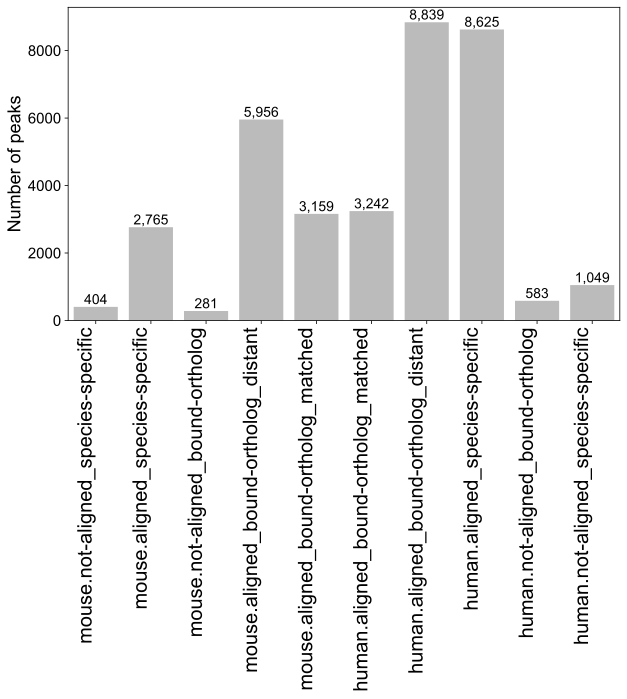

In [ ]:
fig = plt.figure(figsize=(9, 10))
ax1 = fig.add_subplot(1, 1, 1)

sns.barplot(
    data=counts_peaks_orthology_label_3utr.to_frame().reset_index(),
    x="index",
    y="count",
    order=PEAKS_COUNTS_ORDERED_LABELS,
    color="#BBBBBB",
    ax=ax1,
)

_ = ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha="right")
_ = ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=15)

ax1.set_xlabel("")
ax1.set_ylabel("Count")

# Add the numbers above each bar in the plot
for p in ax1.patches:
    ax1.annotate(
        f"{int(p.get_height()):,}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
        color="black",
        size=14,
    )

ax1.set_ylabel("Number of peaks", fontsize=18)
ax1.set_xlabel("", fontsize=18)


plt.tight_layout()

# if params_export_flag:
#    filepath = outputdir / "cross_species_mappability.barplot.svg"
#    plt.savefig(filepath, bbox_inches="tight", dpi=300)

## EXPORT

In [ ]:
h_bound_genes = set(h_full["gene_id"].unique())
m_bound_genes = set(m_full["gene_id"].unique())

h_bound_genes_3utr = set(h_id_to_meta_3utr.loc[h_umap_3utr["identifier"].values, "gene_id"].unique()) | set(
    h_id_to_meta_3utr.loc[h_lift_3utr["identifier.human_source"].values, "gene_id"].unique()
)
m_bound_genes_3utr = set(m_id_to_meta_3utr.loc[m_umap_3utr["identifier"].values, "gene_id"].unique()) | set(
    m_id_to_meta_3utr.loc[m_lift_3utr["identifier.mouse_source"].values, "gene_id"].unique()
)


In [ ]:
# TABLES TO BUILD :

# - Orthologies mapping table
# - Gene lists : [gene_id, status]
# - Peak lists : [identifier, status]


if params_export_flag:
    # ORTHOLOGIES - MAPPING TABLE

    export_orth_table = (
        DATA["orthologs"]
        .loc[
            lambda df: ((df["mouse_ensid"].isin(m_bound_genes_3utr)) | (df["human_ensid"].isin(h_bound_genes_3utr))),
            :,
        ]
        .drop_duplicates()
        .sort_values(by=["mouse_ensid"])
        .reset_index(drop=True)
    )

    export_orth_table.to_csv(
        outputdir / "mappability.orthologies_table.tsv.gz",
        header=True,
        index=False,
        sep="\t",
        compression="gzip",
    )

    # ORTHOLOGIES - ANY BIOTYPE
    # =========================

    export_h_genes = pd.concat(
        [
            pd.Series(list(h_genes_bound_orth_complete), name="ensembl_id").to_frame().assign(label="bound_ortholog"),
            pd.Series(list(h_genes_no_bound_orth_complete), name="ensembl_id")
            .to_frame()
            .assign(label="species_specific"),
        ],
        axis=0,
    )

    export_m_genes = pd.concat(
        [
            pd.Series(list(m_genes_bound_orth_complete), name="ensembl_id").to_frame().assign(label="bound_ortholog"),
            pd.Series(list(m_genes_no_bound_orth_complete), name="ensembl_id")
            .to_frame()
            .assign(label="species_specific"),
        ],
        axis=0,
    )

    export_h_genes.to_csv(
        outputdir / "mappability.any_biotype.human_genes_labeled.tsv.gz",
        header=True,
        index=False,
        sep="\t",
        compression="gzip",
    )

    export_m_genes.to_csv(
        outputdir / "mappability.any_biotype.mouse_genes_labeled.tsv.gz",
        header=True,
        index=False,
        sep="\t",
        compression="gzip",
    )

    # ORTHOLOGIES - 3'UTR
    # ===================

    export_h_genes_3utr = pd.concat(
        [
            pd.Series(list(h_genes_bound_orth_complete_3utr), name="ensembl_id")
            .to_frame()
            .assign(label="bound_ortholog"),
            pd.Series(list(h_genes_no_bound_orth_complete_3utr), name="ensembl_id")
            .to_frame()
            .assign(label="species_specific"),
        ],
        axis=0,
    )

    export_m_genes_3utr = pd.concat(
        [
            pd.Series(list(m_genes_bound_orth_complete_3utr), name="ensembl_id")
            .to_frame()
            .assign(label="bound_ortholog"),
            pd.Series(list(m_genes_no_bound_orth_complete_3utr), name="ensembl_id")
            .to_frame()
            .assign(label="species_specific"),
        ],
        axis=0,
    )

    export_h_genes_3utr.to_csv(
        outputdir / "mappability.3UTR.human_genes_labeled.tsv.gz",
        header=True,
        index=False,
        sep="\t",
        compression="gzip",
    )

    export_m_genes_3utr.to_csv(
        outputdir / "mappability.3UTR.mouse_genes_labeled.tsv.gz",
        header=True,
        index=False,
        sep="\t",
        compression="gzip",
    )

    # PEAKS - ORTHOLOGY LABELS
    # ========================

    # Export the table of orthologies of peak labels and their labels.

    export_h_peaks_orthology_label_3utr = h_peaks_orthology_label_3utr
    export_m_peaks_orthology_label_3utr = m_peaks_orthology_label_3utr

    export_h_peaks_orthology_label_3utr.to_csv(
        outputdir / "mappability.3UTR.human_peaks_labeled.tsv.gz",
        header=True,
        index=False,
        sep="\t",
        compression="gzip",
    )

    export_m_peaks_orthology_label_3utr.to_csv(
        outputdir / "mappability.3UTR.mouse_peaks_labeled.tsv.gz",
        header=True,
        index=False,
        sep="\t",
        compression="gzip",
    )

    ###

#    with pd.ExcelWriter(
#        outputdir / "mappability.orthologous_binding_genes_and_peaks.xlsx", engine="xlsxwriter"
#    ) as writer:
#        export_h_genes.to_excel(writer, sheet_name="1_human_anybiotype_genes")
#        export_m_genes.to_excel(writer, sheet_name="2_mouse_anybiotype_genes")
#        export_h_genes.to_excel(writer, sheet_name="3_human_3UTR_genes")
#        export_m_genes.to_excel(writer, sheet_name="4_mouse_3UTR_genes")
#        export_h_peaks_orthology_label_3utr.to_excel(writer, sheet_name="5_human_3UTR_peaks")
#        export_m_peaks_orthology_label_3utr.to_excel(writer, sheet_name="6_mouse_3UTR_peaks")
#        export_orth_table.to_excel(writer, sheet_name="7_orthologies")
